In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# 网络结构有两种方式，逐步探索

# 构建数据
torch.manual_seed(1)

# 假数据
x = torch.unsqueeze(torch.linspace(-1,1,100),dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

In [3]:
class Net(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(Net,self).__init__()
        self.hidden = torch.nn.Linear(n_feature,n_hidden)
        self.predict = torch.nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        x = torch.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [4]:
model = Net(1,10,1)

optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

print('model state dict')
for param_tensor in model.state_dict():
    print(param_tensor ,'\t',model.state_dict()[param_tensor].size())
    
print('optimizer state dict')
for var_name in optimizer.state_dict():
    print(var_name ,'\t',optimizer.state_dict()[var_name])

model state dict
hidden.weight 	 torch.Size([10, 1])
hidden.bias 	 torch.Size([10])
predict.weight 	 torch.Size([1, 10])
predict.bias 	 torch.Size([1])
optimizer state dict
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140350313583384, 140350313583528, 140350313583600, 140350313583672]}]


In [5]:
# 使用Sequential 构建网络结构
def save():
    model_1 = Net(1,10,1)

    optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01,momentum=0.9)
    loss_func = torch.nn.MSELoss()
    
    # 训练
    for t in range(100):
        prediction = model_1(x)
        loss = loss_func(prediction,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # plot result
    plt.figure(1,figsize=(10,3))
    plt.subplot(131)
    plt.title('model_1')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)
    
    # 有两种途径保存模型
    # 1.保存整个网络
    torch.save(model_1,'./model/class_net.pkl')
    # 2.只保存网络中的参数
    torch.save(model_1.state_dict(),'./model/class_net_parameters.pkl')

In [6]:
# 恢复整个网络
def restore_net():
    model_2 = torch.load('./model/class_net.pkl')
    model_2.eval()
    prediction = model_2(x)
    
    # plot result
    plt.subplot(132)
    plt.title('model_2')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)

In [7]:
# 恢复网络参数
def restore_parameters():  
    model_3 = Net(1,10,1)

    # copy net1 parameters to net3
    model_3.load_state_dict(torch.load('./model/class_net_parameters.pkl'))
    model_3.eval()
    prediction = model_3(x)
    
    # plot result
    plt.subplot(133)
    plt.title('model_3')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)
    plt.show()

/home/fengjiaxin/fengjiaxin/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


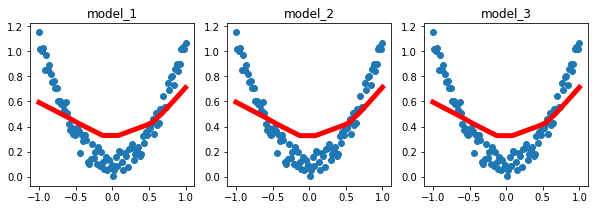

In [8]:
save()
restore_net()
restore_parameters()

In [9]:
# saving and loading a general checkpoint for inference or resuming training
def save_checkpoint():
    model_1 = Net(1,10,1)
    
    optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01,momentum=0.9)
    loss_func = torch.nn.MSELoss()
    
    # 训练，先训练50步，然后在训练100步
    for t in range(50):
        prediction = model_1(x)
        loss = loss_func(prediction,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch 50: %.4f'%loss)     
    # plot result
    plt.figure(1,figsize=(10,3))
    plt.subplot(121)
    plt.title('model_50')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)
    
    # 保存训练的所有信息
    save_dict = {'epoch':t,
                 'model_state_dict':model_1.state_dict(),
                 'optimizer_state_dict':optimizer.state_dict(),
                 'loss':loss
                }
    torch.save(save_dict,'./model/checkpoint.pkl')    

In [10]:
# continue train
def continue_training():
    model_2 = Net(1,10,1)
    optimizer = torch.optim.SGD(model_2.parameters(),lr=0.01,momentum=0.9)
    checkpoint = torch.load('./model/checkpoint.pkl')
    
    model_2.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    prev_epoch = checkpoint['epoch']
    prev_loss = checkpoint['loss']
    
    print('prev_epoch %d'%prev_epoch)
    print('prev_loss %.4f'%prev_loss)
    
    loss_func = torch.nn.MSELoss()
    loss = prev_loss
    
    for epoch in range(prev_epoch+1,100):
        prediction = model_2(x)
        loss = loss_func(prediction,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch 100: %.4f'%loss)     
    # plot result
    plt.figure(1,figsize=(10,3))
    plt.subplot(122)
    plt.title('model_100')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)

epoch 50: 0.0195
prev_epoch 49
prev_loss 0.0195
epoch 100: 0.0065


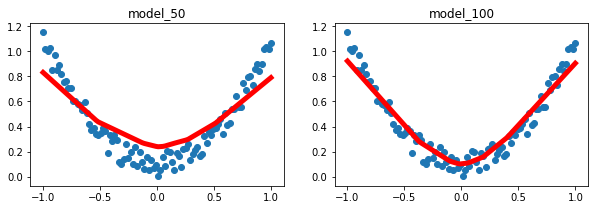

In [11]:
save_checkpoint()
continue_training()

In [12]:
# saving and loading a general checkpoint for inference or resuming training
def test_checkpoint():
    model_1 = Net(1,10,1)

    optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01,momentum=0.9)
    loss_func = torch.nn.MSELoss()

    # 训练，先训练50步，然后在训练100步
    for t in range(100):
        prediction = model_1(x)
        loss = loss_func(prediction,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch 100: %.4f'%loss)     
    # plot result
    plt.figure(1,figsize=(10,3))
    plt.subplot(121)
    plt.title('model_100')
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x.data.numpy(),prediction.data.numpy(),'r-',lw=5)

epoch 100: 0.0172


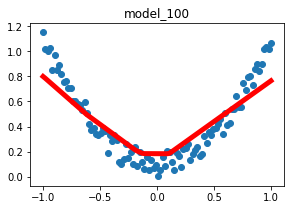

In [13]:
test_checkpoint()